In [74]:
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import tarfile
import urllib.request
import numpy as np

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/titanic/train.csv")), pd.read_csv(Path("datasets/titanic/test.csv"))

titanic_train, titanic_test = load_titanic_data()
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
titanic_train = titanic_train.set_index("PassengerId")
titanic_test = titanic_test.set_index("PassengerId")

In [3]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

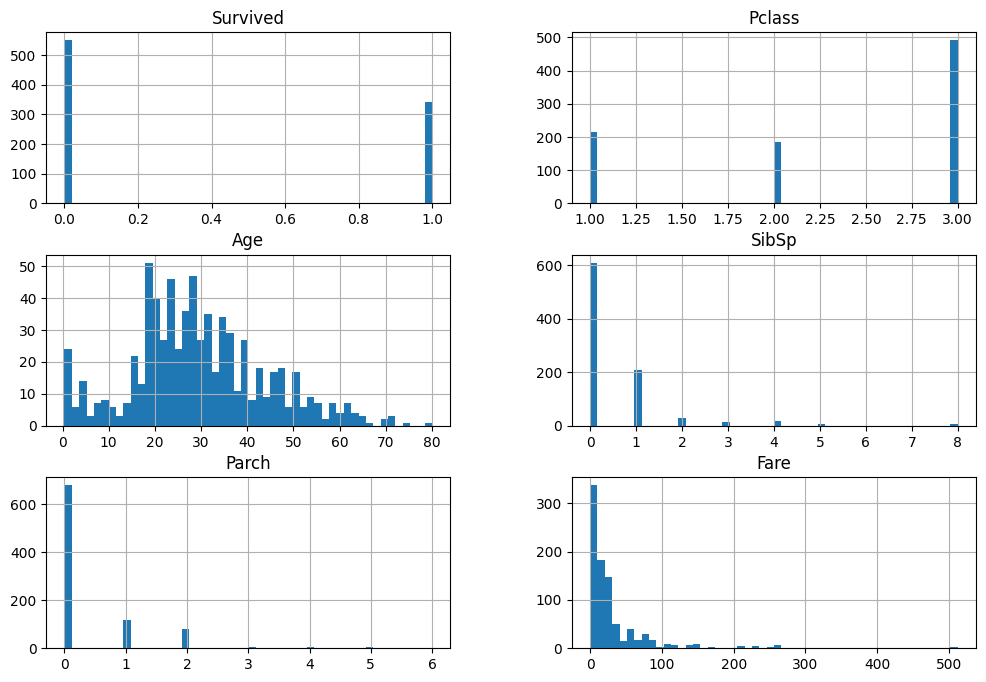

In [5]:
titanic_train.hist(bins=50,figsize=(12,8))

In [6]:
corr_matrix = titanic_train.corr(numeric_only=True)
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [76]:
titanic_train['AgeRange'] = titanic_train['Age'] // 15 * 15 # categorical age
titanic_train['CabinCategory'] = titanic_train['Cabin'].str[0]
titanic_train['TravellingAlone'] = (titanic_train['SibSp'] + titanic_train['Parch'] == 0)

In [8]:
titanic_train['AgeRange'].value_counts()

AgeRange
15.0    306
30.0    215
45.0     89
0.0      78
60.0     25
75.0      1
Name: count, dtype: int64

In [9]:
titanic_train['CabinCategory'].value_counts()

CabinCategory
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

In [10]:
titanic_train['TravellingAlone'].value_counts()

TravellingAlone
True     537
False    354
Name: count, dtype: int64

In [11]:
corr_matrix = titanic_train.corr(numeric_only=True)
corr_matrix['Survived'].sort_values(ascending=False)

Survived           1.000000
Fare               0.257307
Parch              0.081629
SibSp             -0.035322
AgeRange          -0.058848
Age               -0.077221
TravellingAlone   -0.203367
Pclass            -0.338481
Name: Survived, dtype: float64

In [77]:
X_train_raw = titanic_train.drop(["Survived", 'Age', 'SibSp', 'Parch', 'Cabin'], axis=1)

In [78]:
titanic_test['AgeRange'] = titanic_test['Age'] // 15 * 15
titanic_test['CabinCategory'] = titanic_test['Cabin'].str[0]
titanic_test['TravellingAlone'] = (titanic_test['SibSp'] + titanic_test['Parch'] == 0)
titanic_test = titanic_test.drop(['Age', 'SibSp', 'Parch', 'Cabin'], axis=1)

In [73]:
X_train_raw['CabinCategory'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [72]:
titanic_test['CabinCategory'].unique()

array([nan, 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

In [113]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(sparse_output=False))
])
cabin_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(categories=[[0, 1, 2, 3, 4, 5, 6, 7]], sparse_output=False))
])

In [114]:
num_cols = ['Fare']
cat_cols = ['AgeRange', 'Embarked', 'Pclass', 'Sex', 'TravellingAlone']
preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
    ('cabin', cabin_pipeline, ['CabinCategory'])
])

In [115]:
X_train = preprocessing.fit_transform(X_train_raw)
y_train = titanic_train["Survived"].copy()
X_test = preprocessing.fit_transform(titanic_test)

In [17]:
parameters = {'max_depth': np.arange(4,12,1), 'n_estimators': np.arange(50,325,25), 'max_features':('sqrt', 'log2')}
grid_search = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': ('sqrt', 'log2'),
                         'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300])})

In [18]:
grid_search.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}

In [19]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
94,1.818248,0.096773,0.142215,0.069112,8,sqrt,200,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...",0.810056,0.814607,0.876404,0.814607,0.865169,0.836168,0.028536,1
96,2.247019,0.085453,0.155741,0.061316,8,sqrt,250,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...",0.810056,0.808989,0.865169,0.814607,0.876404,0.835045,0.029459,2
104,1.691963,0.108330,0.115073,0.045915,8,log2,175,"{'max_depth': 8, 'max_features': 'log2', 'n_es...",0.793296,0.814607,0.876404,0.814607,0.870787,0.833940,0.033348,3
90,0.826994,0.070922,0.065056,0.024244,8,sqrt,100,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...",0.804469,0.803371,0.865169,0.825843,0.870787,0.833928,0.028988,4
78,0.647026,0.079798,0.064256,0.043091,7,log2,75,"{'max_depth': 7, 'max_features': 'log2', 'n_es...",0.815642,0.814607,0.853933,0.825843,0.859551,0.833915,0.019130,5


In [20]:
parameters = {'C': [1,100], 'gamma': [0.1,5], 'kernel':('poly', 'rbf')}
grid_search_svc = GridSearchCV(SVC(), parameters, n_jobs=-1)
grid_search_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 100], 'gamma': [0.1, 5],
                         'kernel': ('poly', 'rbf')})

In [21]:
grid_search_svc.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [22]:
cv_results_svc = pd.DataFrame(grid_search_svc.cv_results_)
cv_results_svc.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_results_svc.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.119722,0.028184,0.011569,0.001353,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.815642,0.797753,0.842697,0.803371,0.842697,0.820432,0.019078,1
4,0.144965,0.056695,0.005186,0.001828,100,0.1,poly,"{'C': 100, 'gamma': 0.1, 'kernel': 'poly'}",0.810056,0.797753,0.842697,0.803371,0.842697,0.819315,0.019485,2
1,0.067843,0.035423,0.012076,0.001619,1,0.1,rbf,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.815642,0.803371,0.808989,0.786517,0.831461,0.809196,0.014735,3
0,0.024529,0.005240,0.004189,0.000398,1,0.1,poly,"{'C': 1, 'gamma': 0.1, 'kernel': 'poly'}",0.798883,0.808989,0.797753,0.797753,0.831461,0.806968,0.012955,4
2,12.008193,15.290324,0.004987,0.002601,1,5,poly,"{'C': 1, 'gamma': 5, 'kernel': 'poly'}",0.770950,0.764045,0.797753,0.797753,0.808989,0.787898,0.017293,5


In [17]:
parameters = {'alpha': np.arange(0.00005, 0.001, 0.00005), 'max_iter': [250, 500, 1000, 1500], 'tol': np.arange(0.0005, 0.0055, 0.0005), 'eta0': np.arange(0, 0.3, 0.05)}
grid_search_sgd = GridSearchCV(SGDClassifier(), parameters, n_jobs=-1)
grid_search_sgd.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': array([5.0e-05, 1.0e-04, 1.5e-04, 2.0e-04, 2.5e-04, 3.0e-04, 3.5e-04,
       4.0e-04, 4.5e-04, 5.0e-04, 5.5e-04, 6.0e-04, 6.5e-04, 7.0e-04,
       7.5e-04, 8.0e-04, 8.5e-04, 9.0e-04, 9.5e-04]),
                         'eta0': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25]),
                         'max_iter': [250, 500, 1000, 1500],
                         'tol': array([0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 ,
       0.0045, 0.005 ])})

In [18]:
grid_search_sgd.best_params_

{'alpha': 0.0006000000000000001, 'eta0': 0.05, 'max_iter': 1000, 'tol': 0.0035}

In [19]:
cv_results_sgd = pd.DataFrame(grid_search_sgd.cv_results_)
cv_results_sgd.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_results_sgd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta0,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2706,0.003595,0.001190,0.002002,0.003023,0.0006,0.05,1000,0.0035,"{'alpha': 0.0006000000000000001, 'eta0': 0.05,...",0.843575,0.814607,0.837079,0.769663,0.792135,0.811412,0.027634,1
1275,0.006497,0.002488,0.000899,0.000192,0.0003,0.05,1500,0.003,"{'alpha': 0.00030000000000000003, 'eta0': 0.05...",0.787709,0.786517,0.814607,0.814607,0.848315,0.810351,0.022619,2
2559,0.004195,0.001167,0.000399,0.000488,0.00055,0.15,1500,0.005,"{'alpha': 0.00055, 'eta0': 0.15000000000000002...",0.798883,0.820225,0.831461,0.792135,0.797753,0.808091,0.015097,3
4481,0.003788,0.000748,0.000901,0.000192,0.00095,0.2,250,0.001,"{'alpha': 0.0009500000000000001, 'eta0': 0.2, ...",0.810056,0.814607,0.825843,0.792135,0.797753,0.808079,0.012024,4
2018,0.004397,0.000492,0.002200,0.003431,0.00045,0.1,500,0.0045,"{'alpha': 0.00045000000000000004, 'eta0': 0.1,...",0.821229,0.808989,0.797753,0.786517,0.825843,0.808066,0.014566,5


In [27]:
parameters = {'C': np.arange(10, 100, 10), 'tol': np.arange(0.00005, 0.0055, 0.00005), 'max_iter': np.arange(80, 160, 20)}
grid_search_lr = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

c:\Projects\ml_tests\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                         'max_iter': array([ 80, 100, 120, 140]),
                         'tol': array([5.00e-05, 1.00e-04, 1.50e-04, 2.00e-04, 2.50e-04, 3.00e-04,
       3.50e-04, 4.00e-04, 4.50e-04, 5.00e-04, 5.50e-04, 6.00e-04,
       6.50e-04, 7.00e-04, 7.50e-04, 8.00e-04, 8.50e-04, 9.00e-04,
       9.50e-04, 1.00e-03, 1.05e-03, 1.10e-0...
       3.35e-03, 3.40e-03, 3.45e-03, 3.50e-03, 3.55e-03, 3.60e-03,
       3.65e-03, 3.70e-03, 3.75e-03, 3.80e-03, 3.85e-03, 3.90e-03,
       3.95e-03, 4.00e-03, 4.05e-03, 4.10e-03, 4.15e-03, 4.20e-03,
       4.25e-03, 4.30e-03, 4.35e-03, 4.40e-03, 4.45e-03, 4.50e-03,
       4.55e-03, 4.60e-03, 4.65e-03, 4.70e-03, 4.75e-03, 4.80e-03,
       4.85e-03, 4.90e-03, 4.95e-03, 5.00e-03, 5.05e-03, 5.10e-03,
       5.15e-03, 5.20e-03, 5.25e-03, 5.30e-03, 5.35e-03, 5.40e-03,
       5.45e-03])})

In [28]:
grid_search_lr.best_params_

{'C': 20, 'max_iter': 120, 'tol': 5e-05}

In [29]:
cv_results_lr = pd.DataFrame(grid_search_lr.cv_results_)
cv_results_lr.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_results_lr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1962,0.023804,0.004968,0.001004,0.000018,50,120,0.00005,"{'C': 50, 'max_iter': 120, 'tol': 5e-05}",0.793296,0.814607,0.797753,0.792135,0.803371,0.800232,0.008201,1
2691,0.019496,0.003855,0.001300,0.000401,70,80,0.0038,"{'C': 70, 'max_iter': 80, 'tol': 0.00380000000...",0.793296,0.814607,0.797753,0.792135,0.803371,0.800232,0.008201,1
2609,0.022786,0.006900,0.001405,0.000794,60,140,0.00515,"{'C': 60, 'max_iter': 140, 'tol': 0.00515}",0.793296,0.814607,0.797753,0.792135,0.803371,0.800232,0.008201,1
2610,0.020989,0.007129,0.001002,0.000640,60,140,0.0052,"{'C': 60, 'max_iter': 140, 'tol': 0.0052}",0.793296,0.814607,0.797753,0.792135,0.803371,0.800232,0.008201,1
2611,0.022202,0.006911,0.000996,0.000003,60,140,0.00525,"{'C': 60, 'max_iter': 140, 'tol': 0.00525}",0.793296,0.814607,0.797753,0.792135,0.803371,0.800232,0.008201,1


In [126]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth = 8, max_features = 'sqrt', n_estimators = 200, random_state=42)),
        ('svc', SVC(C = 100, gamma = 0.1, kernel = 'rbf', random_state=42)),
        ('sgd', SGDClassifier(alpha = 0.0006, eta0 = 0.05, max_iter = 1000, tol = 0.0035, random_state=42)),
        ('lr', LogisticRegression(C = 20, max_iter = 120, tol = 5e-05, random_state=42))
    ],
    n_jobs=-1
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=8,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svc', SVC(C=100, gamma=0.1, random_state=42)),
                             ('sgd',
                              SGDClassifier(alpha=0.0006, eta0=0.05,
                                            random_state=42, tol=0.0035)),
                             ('lr',
                              LogisticRegression(C=20, max_iter=120,
                                                 random_state=42, tol=5e-05))],
                 n_jobs=-1)

In [127]:
cv_score = cross_val_score(voting_clf, X_train, y_train, cv=10)
pd.Series(cv_score).describe()

count    10.000000
mean      0.827179
std       0.043327
min       0.752809
25%       0.808989
50%       0.815668
75%       0.848315
max       0.898876
dtype: float64

In [123]:
voting_clf_no_lr = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth = 8, max_features = 'sqrt', n_estimators = 200, random_state=42)),
        ('svc', SVC(C = 100, gamma = 0.1, kernel = 'rbf', random_state=42)),
        ('sgd', SGDClassifier(alpha = 0.0006, eta0 = 0.05, max_iter = 1000, tol = 0.0035, random_state=42))
    ],
    n_jobs=-1
)
voting_clf_no_lr.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=8,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svc', SVC(C=100, gamma=0.1, random_state=42)),
                             ('sgd',
                              SGDClassifier(alpha=0.0006, eta0=0.05,
                                            random_state=42, tol=0.0035))],
                 n_jobs=-1)

In [124]:
cv_score_no_lr = cross_val_score(voting_clf_no_lr, X_train, y_train, cv=10)
pd.Series(cv_score_no_lr).describe()

count    10.000000
mean      0.836180
std       0.048987
min       0.752809
25%       0.811798
50%       0.825843
75%       0.859551
max       0.921348
dtype: float64

In [121]:
voting_clf_soft = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth = 8, max_features = 'sqrt', n_estimators = 200, random_state=42)),
        ('svc', SVC(C = 100, gamma = 0.1, kernel = 'rbf', probability=True, random_state=42)),
    ],
    n_jobs=-1,
    voting="soft"
)
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=8,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=100, gamma=0.1, probability=True,
                                  random_state=42))],
                 n_jobs=-1, voting='soft')

In [122]:
cv_score_soft = cross_val_score(voting_clf_soft, X_train, y_train, cv=10)
pd.Series(cv_score_soft).describe()

count    10.000000
mean      0.828327
std       0.049769
min       0.752809
25%       0.800562
50%       0.825843
75%       0.831461
max       0.921348
dtype: float64

In [119]:
rf_clf = RandomForestClassifier(max_depth = 8, max_features = 'sqrt', n_estimators = 200, random_state=42)
cv_score_rf = cross_val_score(rf_clf, X_train, y_train, cv=10)

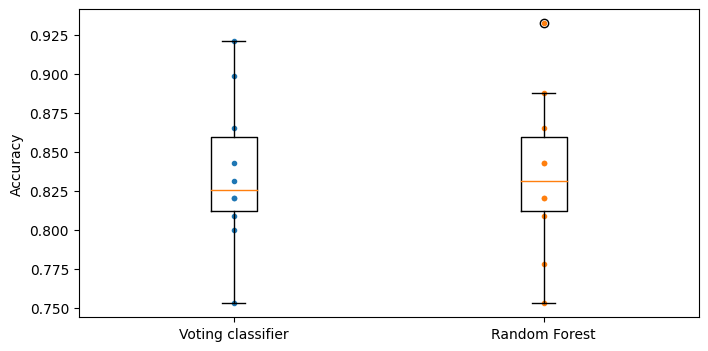

In [125]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, cv_score_no_lr, ".")
plt.plot([2]*10, cv_score_rf, ".")
plt.boxplot([cv_score_no_lr, cv_score_rf], labels=("Voting classifier", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

In [128]:
result = voting_clf_no_lr.predict(X_test)

In [132]:
result_df = pd.DataFrame({'PassengerId': titanic_test.index, 'Survived': result})
result_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [134]:
result_df.to_csv('titanic_predictions.csv', index=False)